In [4]:
#!pip install pingouin
#!pip install pandahouse

import requests
from urllib.parse import urlencode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2
import pandahouse as ph

import warnings
warnings.filterwarnings("ignore")

## A/B–тестирование

**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе ***(А – контроль, B – целевая группа)***

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента

***
Изучим предоставленные данные.

Для начала создадим функцию, получающую на вход список ссылок на файлы и выдающую url этих файлов, которые мы в дальнейшем будем использовать для чтения датафреймов.

In [5]:
def get_urls (links):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    urls = []
    for i in links:
        final_url = base_url + urlencode(dict(public_key = i))
        response = requests.get(final_url)
        download_url = response.json()['href']
        urls.append(download_url)
    return(urls)

In [6]:
#создаем список ссылок, который будем передавать в функцию
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
group_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
all_links = [groups_link, group_add_link, active_studs_link, checks_link]

In [7]:
#применяем функцию и сохраняем ссылки в отдельную переменную
urls = get_urls(all_links)

**Groups** (файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе)

In [8]:
groups = pd.read_csv(urls[0], sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [10]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [12]:
groups.id.nunique()

74484

Видим, что пропущенные значения отсутсвуют, с типами данных все в порядке, групп действительно 2: контрольная и тестовая, правда в тестовой группе значительно больше наблюдений, чем в контрольной. Все пользователи уникальны (кол-во уникальных айди = общему кол-ву айди в датафрейме)
***

**Groups_add** (дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных)

In [13]:
groups_add = pd.read_csv(urls[1], sep=',')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [14]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [15]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [16]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [17]:
groups_add.id.nunique()

92

Видим то же самое: пропущенные значения отсутсвуют, типы данных ок, 2 группы, тестовая так же превосходит контрольную по кол-ву наблюдений, все пользователи уникальны

Объединим датафреймы для дальнейшей работы

In [18]:
all_groups = pd.concat([groups, groups_add])

In [19]:
#еще раз проверим, что все айди уникальны и ничего не задвоилось (все ок)
print('Количество уникальных id: ', all_groups.id.nunique())
print('Общее количество id: ', all_groups.id.count())

Количество уникальных id:  74576
Общее количество id:  74576


***
**Active_studs** (файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента)

In [20]:
active_studs = pd.read_csv(urls[2], sep=',')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [21]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [22]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [23]:
active_studs.student_id.nunique()

8341

По предварительному анализу все ок. Переименуем столбец для дальнейшего мерджа и добавим колонку, с помощью которой затем будем отбирать активных пользователей из общего дф

In [24]:
active_studs = active_studs.rename(columns = {'student_id' : 'id'})

In [25]:
active_studs['activity'] = 1

In [26]:
#объединяем
all_groups_activity = all_groups.merge(active_studs, on = 'id', how='left').fillna(0)

In [27]:
all_groups_activity.head()

,id,grp,activity
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


***
**Checks** (файл с информацией об оплатах пользователей в дни проведения эксперимента)

In [28]:
checks = pd.read_csv(urls[3], sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [29]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [30]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [31]:
checks.student_id.nunique()

541

Все ок, переименовываем столбец, добавляем столбец-маркер оплаты и мерджим

In [32]:
checks = checks.rename(columns = {'student_id' : 'id'})

In [33]:
checks['payment'] = 1

In [34]:
full_df = all_groups_activity.merge(checks, on = 'id', how='left').fillna(0)

In [35]:
full_df.head()

,id,grp,activity,rev,payment
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


In [36]:
#еще раз проверим, что ничего не задвоилось (все ок)
print('Количество уникальных id: ', full_df.id.nunique())
print('Общее количество id: ', full_df.id.count())

Количество уникальных id:  74576
Общее количество id:  74576


In [37]:
#проверяем, что айди тестовой и контрольной групп не пересекаются (все ок)
grp_A = set(full_df.query('grp == "A"').id)
grp_B = set(full_df.query('grp == "B"').id)
grp_A.intersection(grp_B)

set()

<Axes: xlabel='grp', ylabel='Count'>

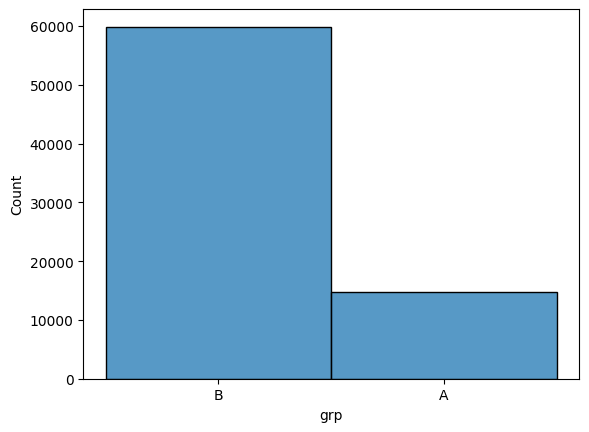

In [38]:
#посмотрим распределение пользоваталей по группам
sns.histplot(data=full_df, x='grp')

Как мы выяснили ранее, кол-во пользователей в тестовой группе действительно в несколько раз превосходит кол-во пользователей в контрольной группе

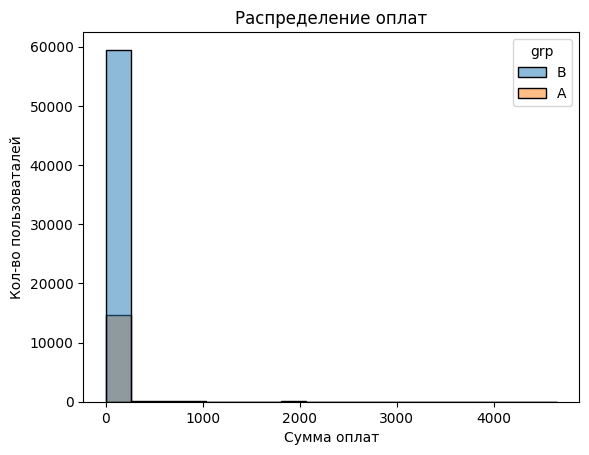

In [39]:
#посмотрим общее распределение оплат с разбивкой по группам
sns.histplot(data=full_df, x='rev', hue = 'grp')

plt.xlabel("Сумма оплат")
plt.ylabel("Кол-во пользоваталей")
plt.title("Распределение оплат")
plt.show()

Видим, что в обеих группах распределение не нормально

In [40]:
#проверим, все ли оплатившие пользователи были активны
full_df.groupby(['activity', 'payment'])\
    .agg({'id' : 'count'})

id
activity payment       
0.0      0.0      66086
         1.0        149
1.0      0.0       7949
         1.0        392

Видим, что есть 149 пользоваталей, которые **не** были **активны**, однако **совершали оплату**. Это может быть объяснено техническим сбоем, ошибкой в данных или автоматическим списанием оплаты (напр., подписка), которая не требует активности пользователя. В любом случае, эти 149 пользователей мы не будем учитывать. Нас интересуют активные пользователи, совершившие оплату (392 человека). Отберем их

In [41]:
target_users = full_df.query('activity == 1 and payment == 1')

In [42]:
target_users.head()

,id,grp,activity,rev,payment
1,1627,A,1.0,990.0000,1.0
220,100300,B,1.0,990.0000,1.0
320,108270,B,1.0,290.0000,1.0
3779,264473,B,1.0,1900.0001,1.0
4187,274352,B,1.0,690.0000,1.0


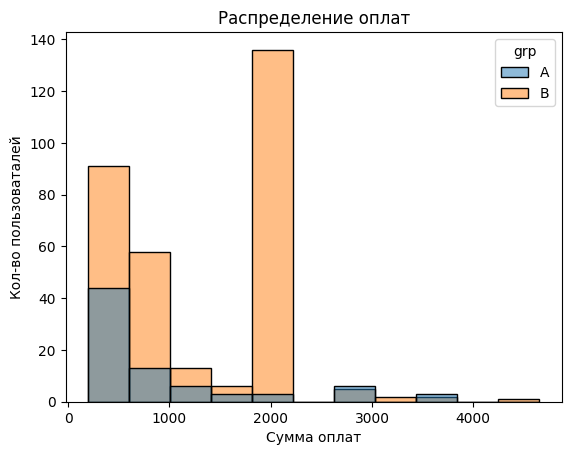

In [43]:
#посмотрим распределение оплат инетерсующих нас пользоваталей с разбивкой по группам
sns.histplot(data=target_users, x='rev', hue = 'grp')

plt.xlabel("Сумма оплат")
plt.ylabel("Кол-во пользоваталей")
plt.title("Распределение оплат")
plt.show()

Видим, что в обеих группах распределение визуально не нормально

***
## **Выбор метрик**
Перейдем к выбору метрик. Поскольку у нас есть данные об оплатах, а бизнес инетересует эффективность новой механики оплаты, мы будем рассматривать денежные метрики.

- **ARPPU** (Revenue / Paying Users)

ARPPU покажет, увеличился ли доход на *платящего* клиента

- **ARPU** (Revenue / All Users)

ARPU покажет, увеличился ли доход на пользователя после внедрения новой механики оплаты

- **AOV** - (Revenue / N of Orders)

AOV покажет, увеличился ли средний чек в тестовой группе  


Также рассмотрим важную метрику аудитории:
- **CR** ((Paying Users / All Users) * 100)

CR покажет, увеличилась ли доля платящих клиентов

Начнем с метрик ARPPU и AOV, поскольку для их расчета необходим датафрейм target_users. Прежде чем проводить тест, необходимо проверить распределения на нормальность и гомогенность.

Проверка на нормальность распределения
- H0 - распределение нормальное
- H1 - распределение не нормальное

р-value = 0.05

In [44]:
pg.normality(data=target_users, dv="rev", group="grp", method="normaltest")

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


р-value меньше 0.05 - отклоняем Н0,  распределение не нормально

Проверка на гомогенность распределения
- H0 - распределение гомогенно
- H1 - распределение не гомогенно

р-value = 0.05

In [45]:
pg.homoscedasticity(data=target_users, dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


р-value больше 0.05 - не можем отклонить Н0, распределение считаем гомогенным

In [46]:
#посмотрим кол-во наблюдений в каждой группе
target_users.groupby('grp', as_index = False).agg({'id' : 'count'})

,grp,id
0,A,78
1,B,314


- Распределения не нормальны
- Распределения гомогенны
- Величины количественные
- Количество наблюдений больше 30

Будем использовать t-test для обеих метрик.

## Метрика ARPPU

- H0 - статистически значимые различия в ARPPU между пользователями групп А и В отсутствуют
- H1 - статистически значимые различия в ARPPU между пользователями групп А и В есть

p-value = 0.05

In [47]:
#расчет вручную
print ('ARPPU в группе А:', (target_users.query('grp == "A"').rev.sum()/target_users.query('grp == "A"').id.nunique()).round(2))
print ('ARPPU в группе B:', (target_users.query('grp == "B"').rev.sum()/target_users.query('grp == "B"').id.nunique()).round(2))

ARPPU в группе А: 933.59
ARPPU в группе B: 1257.88


In [48]:
#t-test
pg.ttest(target_users.query('grp == "A"').rev, target_users.query('grp == "B"').rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


p-value < 0.05, мы отклоняем Н0, значит ARPPU в группах А и В статистически значимо различается.

Таким образом, ARPPU в группе В статистически значимо выше, чем в группе А.

## Метрика AOV

- H0 - статистически значимые различия в AOV между пользователями групп А и В отсутствуют
- H1 - статистически значимые различия в AOV между пользователями групп А и В есть

p-value = 0.05

In [49]:
#расчет вручную
print ('AOV в группе А:', (target_users.query('grp == "A"').rev.sum()/target_users.query('grp == "A"').id.count()).round(2))
print ('AOV в группе B:', (target_users.query('grp == "B"').rev.sum()/target_users.query('grp == "B"').id.count()).round(2))

AOV в группе А: 933.59
AOV в группе B: 1257.88


In [50]:
#t-test
pg.ttest(target_users.query('grp == "A"').rev, target_users.query('grp == "B"').rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


p-value < 0.05, мы отклоняем Н0, значит ARPPU в группах А и В статистически значимо различается.

Таким образом, AOV в группе В статистически значимо выше, чем в группе А. Мы получили такие же показатели AOV, как и ARPPU. Это связано с тем, что каждый пользователь в период эксперимента совершал по 1 заказу, поэтому количество заказов и количество платящих пользователей равны

***
Вернемся к датасету full_df, с помощью которого будем проверять оставшиеся метрики. Прежде чем проводить тест, необходимо проверить распределения на нормальность и гомогенность.

Проверка на нормальность распределения
- H0 - распределение нормальное
- H1 - распределение не нормальное

р-value = 0.05

In [51]:
pg.normality(data=full_df, dv="rev", group="grp", method="normaltest")

,W,pval,normal
grp,,,
B,121311.864167,0.0,False
A,34722.677715,0.0,False


р-value меньше 0.05 - отклоняем Н0,  распределение не нормально

Проверка на гомогенность распределения
H0 - распределение гомогенно
H1 - распределение не гомогенно
р-value = 0.05

In [52]:
pg.homoscedasticity(data=full_df, dv="rev", group="grp")

,W,pval,equal_var
levene,2.998767,0.083332,True


р-value больше 0.05 - не можем отклонить Н0, распределение считаем гомогенным

In [53]:
#посмотрим кол-во наблюдений в каждой группе
full_df.groupby('grp', as_index = False).agg({'id' : 'count'})

,grp,id
0,A,14693
1,B,59883


- Распределения не нормальны
- Распределения гомогенны
- Величины количественные
- Количество наблюдений больше 30

Будем использовать t-test для ARPU и хи-квадрат для CR

## Метрика ARPU

- H0 - статистически значимые различия в ARPU между пользователями групп А и В отсутствуют
- H1 - статистически значимые различия в ARPU между пользователями групп А и В есть

p-value = 0.05

In [54]:
#расчет вручную
print ('ARPU в группе А:', (full_df.query('grp == "A" and activity == 1').rev.sum()/full_df.query('grp == "A" and activity == 1').id.nunique()).round(2))
print ('ARPU в группе B:', (full_df.query('grp == "B" and activity == 1').rev.sum()/full_df.query('grp == "B" and activity == 1').id.nunique()).round(2))

ARPU в группе А: 47.35
ARPU в группе B: 58.06


In [55]:
#t-test
pg.ttest(full_df.query('grp == "A"').rev, full_df.query('grp == "B"').rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.858044,24624.398427,two-sided,0.063175,"[-3.63, 0.1]",0.015943,0.058,0.409821


p-value > 0.05, соотвественно мы **не можем отклонить** нулевую гипотезу. Будем считать, что статистически значимые различия в ARPU между пользователями групп А и В отсутствуют

## Метрика CR
Качественная величина, будем использовать Хи-квадрат.

- H0 - статистически значимые различия в CR между пользователями групп А и В отсутствуют
- H1 - статистически значимые различия в CR между пользователями групп А и В есть

In [56]:
#расчет вручную
CR_A = (target_users.query('grp == "A"').id.nunique()/full_df.query('grp == "A" and activity == 1').id.nunique()) * 100
CR_A = round(CR_A, 2)
CR_B = (target_users.query('grp == "B"').id.nunique()/full_df.query('grp == "B" and activity == 1').id.nunique()) * 100
CR_B = round(CR_B, 2)
print ('CR в группе А:', CR_A)
print ('CR в группе B:', CR_B)

CR в группе А: 5.07
CR в группе B: 4.62


In [57]:
#создаем перекрестную таблицу
crosstab = pd.crosstab(full_df.query('activity == 1').grp, full_df.query('activity == 1').payment)
crosstab

payment,0.0,1.0
grp,,
A,1460,78
B,6489,314


In [58]:
#хи-квадрат
stat, p, dof, expected = ss.chi2_contingency(crosstab, correction=True, lambda_=None)
p

0.48625240457231045

p-value > 0.05, соотвественно мы **не можем отклонить** нулевую гипотезу. Считаем, что статистически значимые различия в CR между пользователями групп А и В отсутствуют

## Выводы по a/b тесту:

Для анализа были взяты следующие метрики: метрика аудитории CR и денежные метрики ARPU, ARPPU, AOV.

По результатам а/б тестов:
- CR в группах статистически значимо **не различается**
- ARPU в группах статистически значимо **не различается**

- ARPPU в группах **имеют** статистически значимые **различия**, в тестовой группе ARPPU **выше**
- AOV в группах имеют статистически значимые различия, в тестовой группе AOV выше и равен ARPPU, что обсусловлено спецификой данных


***Стоит ли запускать новую механику на всех пользователей?***

На основе полученных выше данных я бы не рекомендовала внедрять новую механику оплаты, поскольку:
- Кол-во наблюдений в тестовой и контрольных группах сильно различается, возможно необходимо скорректировать систему сплитования или выяснить иную причину сильных различий в количестве
- В данных имеются неоднозначные наблюдения (неактивные пользователи совершали оплату) - этот момент необходимо прояснить
- По результатам а/б тестов новая механика оплаты оказывает статистически значимое положительное влияние только на средний чек/доход с одного клиента, при этом статистически значимо не влияет на более важную бизнесовую метрику - конверсию, а также не влияет на доход с одного пользователя.

Я бы рекомендовала устранить недочеты в данных, связанные с кол-вом наблюдений в группах и непонятными оплатами, и провести тестирование заново, затем принимать решение о внедрении новой механики оплаты. На данный момент я бы не стала внедрять новую механику оплаты.